<a href="https://colab.research.google.com/github/rud-rax/nlp-p2.2/blob/Jakob/3_wordnet_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. WordNet Analysis

This notebook implements the WordNet-based similarity analysis with 4 different configurations:
- With/without stop words
- With/without lemmatization

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

# Download NLTK resources
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Set up for displaying plots
%matplotlib inline
plt.style.use('ggplot')
sns.set(font_scale=1.2)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


## Load Document Data

In [3]:
# Load documents from CSV
docs_df = pd.read_csv('drive/MyDrive/NLP 2_2/documents.csv')
document_texts = docs_df['text'].tolist()

# Load the original human similarity matrix for comparison later
human_similarity_matrix = np.load('drive/MyDrive/NLP 2_2/human_similarity_matrix.npy')

print(f"Loaded {len(document_texts)} documents")
print(f"Human similarity matrix shape: {human_similarity_matrix.shape}")

# Display a few document texts
for i, text in enumerate(document_texts[:5]):
    print(f"Document {i+1}: {text}")

Loaded 50 documents
Human similarity matrix shape: (50, 50)
Document 1: The cyber-attacker accessed your computer files.
Document 2: The cyber-attacker accessed your computer programs.
Document 3: The cyber-attacker accessed your information stored in an Internet site.
Document 4: The cyber-attacker caused a program on your computer to crash.
Document 5: The cyber-attacker caused your computer program to run very slowly.


## Functions for WordNet Processing

In [4]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    """
    Convert Penn Treebank POS tags to WordNet POS tags.

    Args:
        treebank_tag: Penn Treebank POS tag

    Returns:
        WordNet POS tag (n, v, a, r, s) or None if not mappable
    """
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    elif treebank_tag.startswith('S'):
        return 's'  # Adjective satellite
    else:
        return None  # Not a tag that maps to WordNet

In [5]:
def extract_synsets(text, remove_stop_words=False, apply_lemmatization=False):
    """
    Extract WordNet synsets from text.

    Args:
        text: The input text
        remove_stop_words: Whether to remove stop words
        apply_lemmatization: Whether to apply lemmatization

    Returns:
        List of WordNet synsets
    """
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words if specified
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]

    # Perform POS tagging
    pos_tags = nltk.pos_tag(tokens)

    # Extract synsets
    synsets = []
    for token, pos in pos_tags:
        # Convert TreeBank tag to WordNet tag
        wordnet_pos = get_wordnet_pos(pos)

        # Skip tokens with POS tags that don't map to WordNet
        if wordnet_pos is None:
            continue

        # Apply lemmatization if specified
        if apply_lemmatization:
            token = lemmatizer.lemmatize(token, pos=wordnet_pos)

        # Get synsets for this token
        token_synsets = wn.synsets(token, pos=wordnet_pos)

        # Add the first synset (most common) if any exist
        if token_synsets:
            synsets.append(token_synsets[0])

    return synsets

In [6]:
def compute_wordnet_similarity(synsets1, synsets2):
    """
    Compute similarity between two lists of synsets using the Greedy Lemma Aligning Overlap method.

    Args:
        synsets1: First list of synsets
        synsets2: Second list of synsets

    Returns:
        Similarity score between 0 and 1
    """
    if not synsets1 or not synsets2:
        return 0.0

    # Calculate path similarity for all pairs
    similarities = []
    for s1 in synsets1:
        for s2 in synsets2:
            # Check if they're comparable (same POS)
            if s1.pos() == s2.pos():
                # Try to get path similarity
                try:
                    sim = s1.path_similarity(s2)
                    if sim is not None:
                        similarities.append(sim)
                except:
                    continue

    # If no valid similarities found, return 0
    if not similarities:
        return 0.0

    # Greedy approach: take the average of the top similarities
    # For each synset in the shorter list, find its best match in the longer list
    if len(synsets1) <= len(synsets2):
        shorter, longer = synsets1, synsets2
    else:
        shorter, longer = synsets2, synsets1

    best_matches = []
    for s1 in shorter:
        best_match = 0.0
        for s2 in longer:
            if s1.pos() == s2.pos():
                try:
                    sim = s1.path_similarity(s2)
                    if sim is not None and sim > best_match:
                        best_match = sim
                except:
                    continue
        if best_match > 0:
            best_matches.append(best_match)

    # Return average of best matches
    if best_matches:
        return sum(best_matches) / len(best_matches)
    else:
        return 0.0

In [7]:
def generate_wordnet_configurations():
    """
    Generate all 4 preprocessing configurations for WordNet.

    Returns:
        List of 4 configurations as tuples:
        (config_id, stop_words_included, lemmatization_applied)
    """
    configurations = []
    config_id = 1

    for stop_words_included in [False, True]:
        for lemmatization_applied in [False, True]:
            configurations.append((config_id, stop_words_included, lemmatization_applied))
            config_id += 1

    return configurations

In [8]:
def process_wordnet_configurations(document_texts, configurations):
    """
    Process all WordNet configurations.

    Args:
        document_texts: List of document texts
        configurations: List of configuration tuples

    Returns:
        Dictionary mapping config_id to similarity matrix
    """
    results = {}

    print("Processing WordNet configurations...")

    for config_id, stop_words_included, lemmatization_applied in tqdm(configurations):
        # Extract synsets for each document
        doc_synsets = []
        for text in document_texts:
            synsets = extract_synsets(text, stop_words_included, lemmatization_applied)
            doc_synsets.append(synsets)

        # Compute similarity matrix
        n_docs = len(document_texts)
        sim_matrix = np.zeros((n_docs, n_docs))

        for i in range(n_docs):
            for j in range(n_docs):
                sim_matrix[i, j] = compute_wordnet_similarity(doc_synsets[i], doc_synsets[j])

        # Save the result
        results[config_id] = sim_matrix

        # Save the matrix to a file
        np.save(f"drive/MyDrive/NLP 2_2/wordnet_config_{config_id}_similarity.npy", sim_matrix)

        # Also save the synsets for reference
        with open(f"drive/MyDrive/NLP 2_2/wordnet_config_{config_id}_synsets.txt", 'w') as f:
            for i, synsets in enumerate(doc_synsets):
                f.write(f"Document {i+1}:\n")
                for synset in synsets:
                    f.write(f"  {synset.name()} - {synset.definition()}\n")
                f.write("\n")

    return results

In [9]:
# Run the WordNet analysis
wordnet_configurations = generate_wordnet_configurations()

# Display the configurations
print("WordNet Configurations:")
for config_id, stop_words_included, lemmatization_applied in wordnet_configurations:
    print(f"Config {config_id}: Stop Words: {'Yes' if stop_words_included else 'No'}, Lemmatization: {'Yes' if lemmatization_applied else 'No'}")

WordNet Configurations:
Config 1: Stop Words: No, Lemmatization: No
Config 2: Stop Words: No, Lemmatization: Yes
Config 3: Stop Words: Yes, Lemmatization: No
Config 4: Stop Words: Yes, Lemmatization: Yes


In [14]:
# Process all WordNet configurations
wordnet_similarity_matrices = process_wordnet_configurations(document_texts, wordnet_configurations)

Processing WordNet configurations...


100%|██████████| 4/4 [00:17<00:00,  4.29s/it]


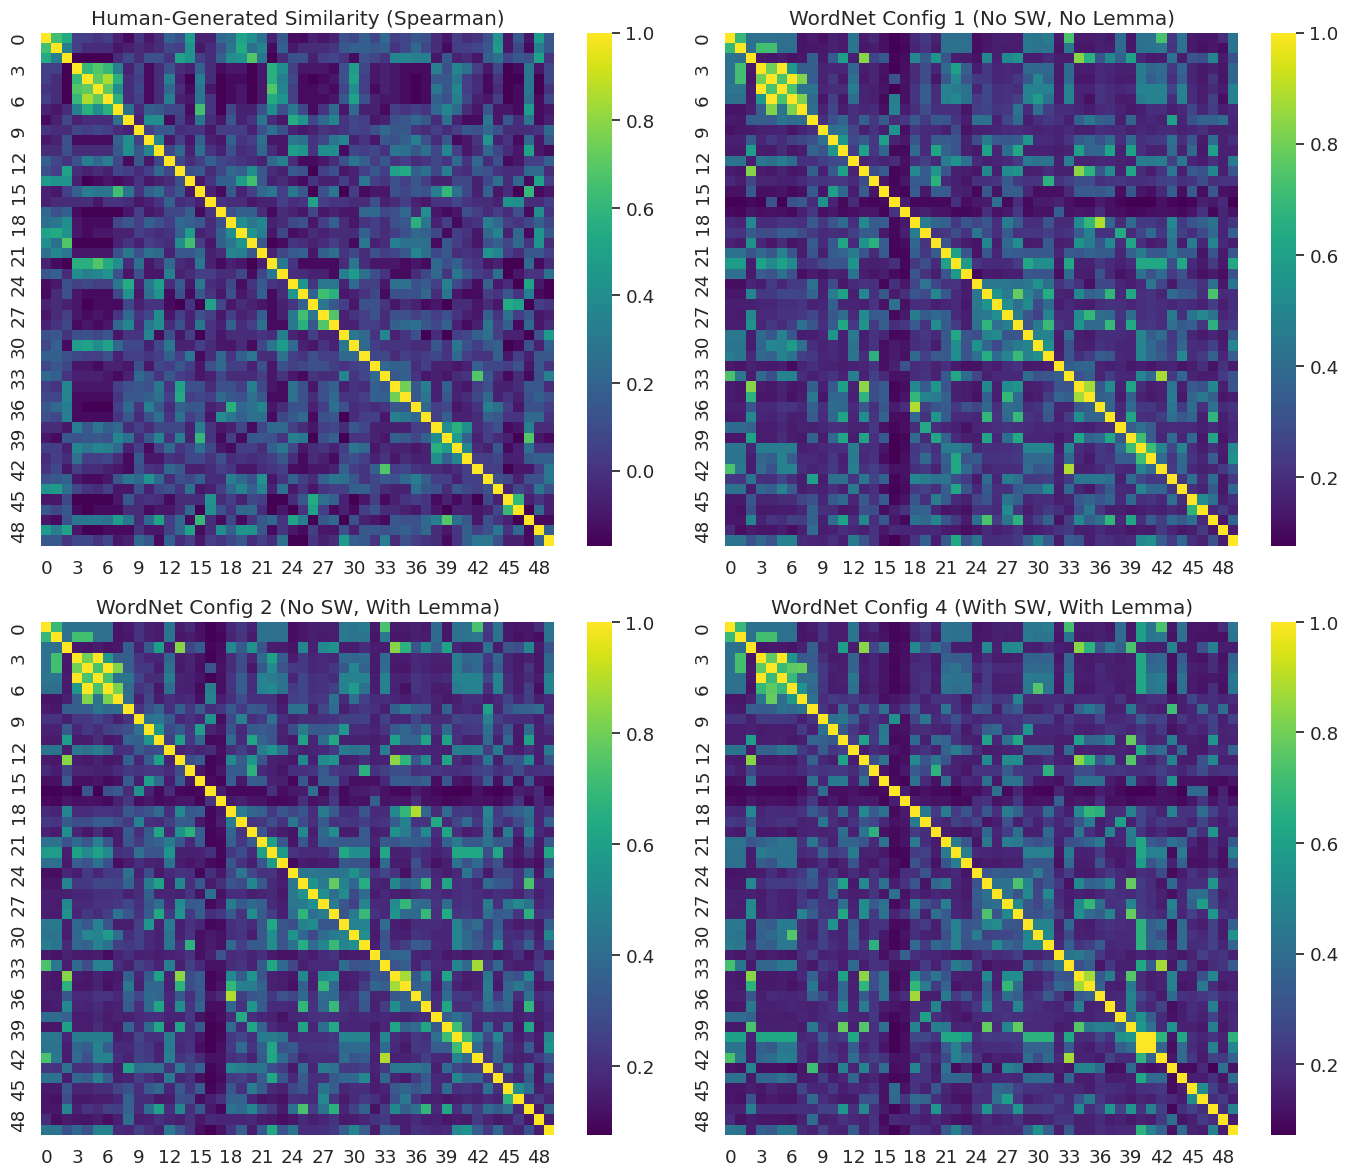

In [15]:
# Visualize a sample of WordNet similarity matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot human similarity matrix
sns.heatmap(human_similarity_matrix, cmap='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Human-Generated Similarity (Spearman)')

# Plot WordNet Config 1 (No stop words, No lemmatization)
wordnet_config1 = wordnet_similarity_matrices[1]
sns.heatmap(wordnet_config1, cmap='viridis', ax=axes[0, 1])
axes[0, 1].set_title('WordNet Config 1 (No SW, No Lemma)')

# Plot WordNet Config 2 (No stop words, With lemmatization)
wordnet_config2 = wordnet_similarity_matrices[2]
sns.heatmap(wordnet_config2, cmap='viridis', ax=axes[1, 0])
axes[1, 0].set_title('WordNet Config 2 (No SW, With Lemma)')

# Plot WordNet Config 4 (With stop words, With lemmatization)
wordnet_config4 = wordnet_similarity_matrices[4]
sns.heatmap(wordnet_config4, cmap='viridis', ax=axes[1, 1])
axes[1, 1].set_title('WordNet Config 4 (With SW, With Lemma)')

plt.tight_layout()
plt.savefig('wordnet_similarity_matrix_samples.png', dpi=300)
plt.show()

In [16]:
# Save the configuration information to a CSV file
config_df = pd.DataFrame([
    {'config_id': config_id,
     'stop_words_included': 'Yes' if stop_words else 'No',
     'lemmatization_applied': 'Yes' if lemmatization else 'No'}
    for config_id, stop_words, lemmatization in wordnet_configurations
])

config_df.to_csv('drive/MyDrive/NLP 2_2/wordnet_configurations.csv', index=False)
print("WordNet configuration information saved to wordnet_configurations.csv")
config_df.head()

WordNet configuration information saved to wordnet_configurations.csv


,config_id,stop_words_included,lemmatization_applied
0,1,No,No
1,2,No,Yes
2,3,Yes,No
3,4,Yes,Yes
